Data visualization and results

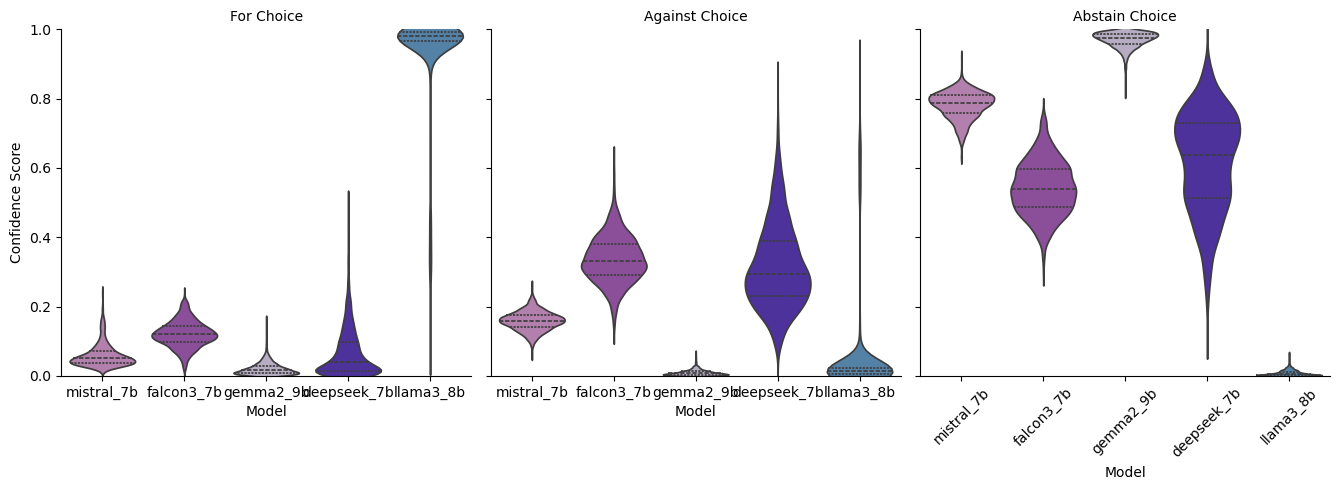

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os

# Define your preferred model order and colors
model_names = [
    "mistral_7b", "falcon3_7b", "gemma2_9b", "deepseek_7b", 
    "llama3_8b"
]

colors_models = ['#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#4682B4']
palette_dict = dict(zip(model_names, colors_models))

# Load your data
file_paths = glob.glob("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/Second_Experiments_Results/*_results_ideology_ES_prompt=1.csv") 

dfs = []

for path in file_paths:
    model_name = os.path.basename(path).split("_results")[0]
    df = pd.read_csv(path)
    
    df_long = df.melt(
        id_vars=["id", "initiative"],
        value_vars=[
            f"{model_name}_for_prob",
            f"{model_name}_against_prob",
            f"{model_name}_abstain_prob"
        ],
        var_name="Choice",
        value_name="Confidence"
    )
    
    df_long["Choice"] = df_long["Choice"].str.replace(f"{model_name}_", "").str.replace("_prob", "").str.capitalize()
    df_long["Model"] = model_name
    dfs.append(df_long)

# Combine all into one DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Filter only models you want to plot (in case not all exist in files)
combined_df = combined_df[combined_df["Model"].isin(model_names)]

# Faceted violin plot with your custom order and color palette
g = sns.catplot(
    x="Model",
    y="Confidence",
    hue="Model",  # Add this!
    col="Choice",
    data=combined_df,
    kind="violin",
    height=5,
    aspect=0.9,
    order=model_names,
    col_order=["For", "Against", "Abstain"],
    inner="quartile",
    palette=palette_dict,
    legend=False  # Suppress redundant legend
)

g.set_titles("{col_name} Choice")
g.set_axis_labels("Model", "Confidence Score")
g.set(ylim=(0, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Political parties plot

Citing the data:
    Bakker, R., Jolly, S., Polk, J., et al. (2020). Chapel Hill Expert Survey (CHES) 2019. [Dataset]. https://chesdata.eu

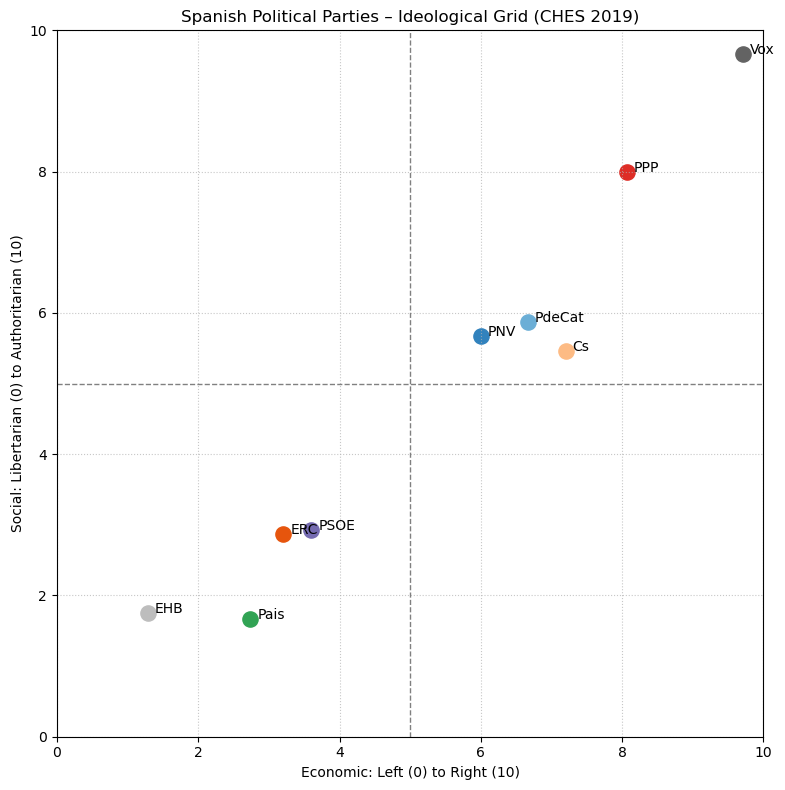

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------
# 1. Load the CHES 2019 Dataset
# -------------------------------------------
ches_df = pd.read_csv("CHES2019V3.csv")  # Replace with your actual file path

# -------------------------------------------
# 2. Filter for Spanish Parties (country code = 5)
# -------------------------------------------
spanish_parties = ches_df[ches_df["country"] == 5]

# -------------------------------------------
# 3. Map Your Selected Parties to CHES Naming
# -------------------------------------------
party_mapping = {
    'Ciudadanos': 'Cs',
    'Más País': 'Pais',
    'EAJ-PNV': 'PNV',
    'PP': 'PPP',
    'PSOE': 'PSOE',
    'ERC': 'ERC',
    'VOX': 'Vox',
    'EH Bildu': 'EHB',
    'Junts': 'PdeCat'  # Historical alias for Junts
}

# This preserves the party order you want
party_order = list(party_mapping.keys())
ches_party_names = [party_mapping[p] for p in party_order]

# Filter only those Spanish parties in your list
selected_parties = spanish_parties[spanish_parties["party"].isin(ches_party_names)]

# -------------------------------------------
# 4. Extract Coordinates and Sort by Your Order
# -------------------------------------------
# Create a DataFrame with 'party', 'lrgen', 'galtan'
ideology_data = selected_parties[["party", "lrgen", "galtan"]]

# Reindex to preserve the custom order (by mapping reversed)
# Reindex to preserve the custom order (by mapping reversed)
party_index_map = {v: i for i, v in enumerate(ches_party_names)}
ideology_data = ideology_data.copy()  # prevent SettingWithCopyWarning
ideology_data.loc[:, "sort_order"] = ideology_data["party"].map(party_index_map)
ideology_data = ideology_data.sort_values("sort_order")

# -------------------------------------------
# 5. Define Colors (One per Party, in Order)
# -------------------------------------------
party_colors = [
    "#fdbb84",  # Ciudadanos – light orange
    "#31a354",  # Más País – green
    "#3182bd",  # EAJ-PNV – blue
    "#de2d26",  # PP – red
    "#756bb1",  # PSOE – purple
    "#e6550d",  # ERC – dark orange
    "#636363",  # VOX – gray
    "#bdbdbd",  # EH Bildu – light gray
    "#6baed6"   # Junts (PdeCat) – sky blue
]

# -------------------------------------------
# 6. Plot the Political Compass
# -------------------------------------------
plt.figure(figsize=(10, 8))

# Scatter plot each party with its assigned color
for i, (_, row) in enumerate(ideology_data.iterrows()):
    plt.scatter(row["lrgen"], row["galtan"], s=120, color=party_colors[i])
    plt.text(row["lrgen"] + 0.1, row["galtan"], row["party"], fontsize=10)

# Axis lines to show quadrants
plt.axhline(y=5, color='gray', linestyle='--', linewidth=1)
plt.axvline(x=5, color='gray', linestyle='--', linewidth=1)

# Labels and formatting
plt.xlabel("Economic: Left (0) to Right (10)" )# [lrgen]
plt.ylabel("Social: Libertarian (0) to Authoritarian (10)") # [galtan]
plt.title("Spanish Political Parties – Ideological Grid (CHES 2019)")
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.gca().set_aspect('equal', adjustable='box')  # Force square aspect
plt.show()


In [7]:
Benchmark

NameError: name 'Benchmark' is not defined

In [9]:
# -------------------------------------------
# 1. Load the Benchmark Dataset of Initiatives
# -------------------------------------------
# This benchmark dataset contains voting records on legislative initiatives in Spain from 2016 to 2025.
# Each row is one initiative; columns show votes from different parties and metadata.
initiatives_path = "/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv"
initiatives_df = pd.read_csv(initiatives_path)

# -------------------------------------------
# 2. Explore the Dataset Structure
# -------------------------------------------
# Check the first few rows to see what the data looks like
print(df.head())

# Print column names to understand what information is available
print("\nAvailable columns:")
print(df.columns.tolist())
initiatives_preview, columns_list

# -------------------------------------------
# 🗳️ 3. Count How Many Initiatives [a party] Voted On
# -------------------------------------------
# In this dataset, party votes are stored in columns named after parties.
# Vote values seem to be:
#   - 1 = Voted in favor
#   - 0 = Voted against
#   - NaN = Did not vote or was absent

# Count how many initiatives have a recorded vote (not NaN) from CUP
# ciudadanos_votes_count = df["..."].notna().sum()

# print(f"\n✅ [Party] participated in {cup_votes_count} initiatives (voted for, against, or abstained).")

   Unnamed: 0          id                                         initiative  \
0           0  042/000002  Dictamen de la Comisión del Estatuto de los Di...   
1           1  042/000003  Dictamen de la Comisión del Estatuto de los Di...   
2           2  042/000010  Dictamen de la Comisión del Estatuto de los Di...   
3           3  042/000011  Dictamen de la Comisión del Estatuto de los Di...   
4           4  042/000012  Dictamen de la Comisión del Estatuto de los Di...   

   llama3_8b_vote  llama3_8b_for_prob  llama3_8b_against_prob  \
0               1            0.975361                0.009537   
1               1            0.975361                0.009537   
2               1            0.975361                0.009537   
3               1            0.975361                0.009537   
4               1            0.975361                0.009537   

   llama3_8b_abstain_prob  
0                0.015102  
1                0.015102  
2                0.015102  
3               

NameError: name 'initiatives_preview' is not defined

New dataset with all party votes and LLM votes

In [12]:
import pandas as pd

# -------------------------------------------
# 1. Load Benchmark and LLM Results
# -------------------------------------------
benchmark_df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv")

llm_all_df = pd.concat([
    pd.read_csv("Second_Experiments_Results/falcon3_7b_results_ideology_ES_prompt=1.csv"),
    pd.read_csv("Second_Experiments_Results/gemma2_9b_results_ideology_ES_prompt=1.csv"),
    pd.read_csv("Second_Experiments_Results/llama3_8b_results_ideology_ES_prompt=1.csv"),
    pd.read_csv("Second_Experiments_Results/deepseek_7b_results_ideology_ES_prompt=1.csv"),
    pd.read_csv("Second_Experiments_Results/mistral_7b_results_ideology_ES_prompt=1.csv")
], ignore_index=True)

# -------------------------------------------
# 2. Melt LLM Result Columns to Long Format
# -------------------------------------------
vote_columns = [
    'falcon3_7b_vote',
    'gemma2_9b_vote',
    'llama3_8b_vote',
    'deepseek_7b_vote',
    'mistral_7b_vote'
]

vote_melted_df = llm_all_df.melt(
    id_vars=["id", "initiative"],
    value_vars=vote_columns,
    var_name="model_vote_column",
    value_name="llm_vote"
)

vote_melted_df["model"] = vote_melted_df["model_vote_column"].str.replace("_vote", "", regex=False)

# -------------------------------------------
# 3. Pivot So Models Become Columns
# -------------------------------------------
llm_wide_df = vote_melted_df.pivot_table(
    index=["id", "initiative"],
    columns="model",
    values="llm_vote"
).reset_index()

# -------------------------------------------
# 4. Merge with Full Benchmark on id + initiative
# -------------------------------------------
merged_df = pd.merge(benchmark_df, llm_wide_df, on=["id", "initiative"], how="left")

# -------------------------------------------
# 5. Save Final Dataset with All Original Columns + Model Votes
# -------------------------------------------
# merged_df.to_csv("all_initiatives_full_with_llm_votes.csv", index=False)
print(" Saved: all_initiatives_full_with_llm_votes.csv")


 Saved: all_initiatives_full_with_llm_votes.csv


In [14]:
# ========== CONFIGURATION FOR LLM POLITICAL BIAS ANALYSIS IN SPAIN ==========

import numpy as np

# Seed for reproducibility
RANDOM_SEED = 2025
np.random.seed(RANDOM_SEED)

# Experiment flags
DEBUG = False
exp_var = 1
remove_minor_parties = False  # You can toggle this for subsetting
results_folder = 'results'
results_latex_folder = 'results_latex'

# Spanish political party codes (used in dataset)
party_codes = [
    'Ciudadanos',
    'Más País',
    'EAJ-PNV',
    'PP',
    'PSOE',
    'CUP',
    'ERC',
    'VOX',
    'EH Bildu',
    'Junts'
]

# Full party names in Spanish (if needed for visualization or prompts)
party_names_ES = [
    'Ciudadanos',
    'Más País',
    'Euzko Alderdi Jeltzalea - Partido Nacionalista Vasco',
    'Partido Popular',
    'Partido Socialista Obrero Español',
    "Candidatura d'Unitat Popular",
    'Esquerra Republicana de Catalunya',
    'Vox',
    'Euskal Herria Bildu',
    'Junts per Catalunya'
]

# Subsets for testing or filtering
party_names_ES_ex_small = ["PSOE", "PP", "VOX"]
party_codes_ex_small = ["psoe", "pp", "vox"]

# Ideological tags (optional use)
direction_ES = ['izquierda', 'derecha', 'centro']
direction_codes = ['left', 'right', 'center']

# ========== MODEL DEFINITIONS ==========

# Full model names (used in processing)
llama3_name = 'Llama3-instruct'
llama70_name = 'Llama3-70B-instruct'
mistral_name = 'Mistral-instruct'
gemma2_name = 'Gemma2-instruct'
falcon3_name = 'Falcon3-instruct'
deepseek_name = 'DeepSeek-instruct'

# Short names for display
llama3_name_short = 'LLaMA 3 8B'
llama70_name_short = 'LLaMA 3 70B'
mistral_name_short = 'Mistral'
gemma2_name_short = 'Gemma 2'
falcon3_name_short = 'Falcon 3'
deepseek_name_short = 'DeepSeek'

# Final model list
model_names = [
    mistral_name,
    falcon3_name,
    gemma2_name,
    deepseek_name,
    llama3_name,
    # llama70_name  # Add this if you have 70B results later
]

model_names_short = {
    mistral_name: mistral_name_short,
    falcon3_name: falcon3_name_short,
    gemma2_name: gemma2_name_short,
    deepseek_name: deepseek_name_short,
    llama3_name: llama3_name_short,
    # llama70_name: llama70_name_short,
}

model_names_short_list = [model_names_short[m] for m in model_names]

# Color scheme (matches your violin plot)
colors_models = ['#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#4682B4']

# Results file pattern (same suffix for each model)
results_suffix = '_results_ideology_ES_prompt=1.csv'

# Folder to output LaTeX tables (if later needed)
results_latex_file = f'{results_latex_folder}/process_results_{exp_var}.tex'



In [16]:
# Make sure the folder exists before writing to the file
os.makedirs(results_latex_folder, exist_ok=True)

# make sure we start with an empty file
open(results_latex_file, 'w').close()

# move to utils
def write_to_latex(latex_text):
    # Write all macros to a file (e.g., tables_macros.tex).
    print("write to latex")
    print(latex_text)
    with open(results_latex_file, "a") as f_out:
        f_out.write(latex_text+"\n\n")


def write_latex_variable(var_name, var_value):
    latex_text = f"\\newcommand{{\\{var_name}}}{{{var_value}}}\\ignorespaces\n"
    write_to_latex(latex_text)


Prompt search

In [23]:
# Folder where model result CSVs are stored
results_folder = "results"

# Load your data
file_paths = glob.glob("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/Second_Experiments_Results/*_results_ideology_ES_prompt=1.csv") 

# List to store cleaned DataFrames
dfs = []

# Loop through files, standardize column names, and tag with model name
for file in file_paths:
    model_name = os.path.basename(file).split("_results")[0]  # e.g., llama3_8b
    df = pd.read_csv(file)

    # Rename model-specific probability columns to generic ones
    df.rename(columns={
        f"{model_name}_for_prob": "for_prob",
        f"{model_name}_against_prob": "against_prob",
        f"{model_name}_abstain_prob": "abstain_prob",
        f"{model_name}_vote": "vote"
    }, inplace=True)

    df["Model"] = model_name
    dfs.append(df)

# Combine all model data
df_all = pd.concat(dfs, ignore_index=True)

# Group by model and compute average scores
df_summary = df_all.groupby("Model")[["for_prob", "against_prob", "abstain_prob"]].mean().reset_index()

# Convert to percentages
df_summary[["for_prob", "against_prob", "abstain_prob"]] *= 100

# Rename for readability
df_summary.rename(columns={
    "for_prob": "For (%)",
    "against_prob": "Against (%)",
    "abstain_prob": "Abstain (%)"
}, inplace=True)

# Set index for LaTeX export
df_summary.set_index("Model", inplace=True)

# Export to LaTeX string
latex_code = df_summary.to_latex(float_format="%.2f")
print(latex_code)

# (Optional) save to file if needed
save_latex = False
if save_latex:
    latex_output_path = "results_latex/model_confidence_summary.tex"
    os.makedirs(os.path.dirname(latex_output_path), exist_ok=True)
    with open(latex_output_path, "w") as f:
        f.write(latex_code)

\begin{tabular}{lrrr}
\toprule
 & For (%) & Against (%) & Abstain (%) \\
Model &  &  &  \\
\midrule
deepseek_7b & 6.59 & 31.66 & 61.75 \\
falcon3_7b & 12.11 & 33.67 & 54.22 \\
gemma2_9b & 2.08 & 0.92 & 96.99 \\
llama3_8b & 93.86 & 5.33 & 0.82 \\
mistral_7b & 5.96 & 15.88 & 78.16 \\
\bottomrule
\end{tabular}



Samples of initiatives

In [110]:
import pandas as pd

# Load a single model file (any will do for the sample initiatives)
sample_df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv")

print("FINAL DATASET AUDIT\n" + "-"*40)
print("Total rows (model × initiative × party):", len(df))

# Check column types
print("\nColumn Overview:")
print(df.dtypes)

# ========== LaTeX Table Renderer ==========

def render_latex_table(df, table_name):
    col1 = df.columns[1]
    lines = [
        r"\begin{table}[H]",
        r"\centering",
        r"\begin{center}",
        r"\begin{tabularx}{\linewidth}{| l | X |}",
        r"  \hline",
        rf"  \thead{{\textbf{{Id}}}} & \thead{{\textbf{{{col1}}}}} \\",
        r"  \hline",
    ]
    for _, row in df.iterrows():
        lines.append(f"{row['id']} & {row[col1]} \\\\")
        lines.append(r"\hline")
    lines += [
        r"\end{tabularx}",
        r"\end{center}",
        rf"\caption{{Ejemplos de iniciativas - {col1}}}",
        rf"\label{{tab:{col1.replace(' ', '').replace('(', '').replace(')', '')}}}",
        r"\end{table}"
    ]
    return "\n".join(lines)

# ========== Generate LaTeX and Macro Definition ==========

latex = render_latex_table(sample_df[:10], "Iniciativa (ES)")
latex = latex.replace('%', r'\%')  # escape % for LaTeX

macro_definition = (
    r"\newcommand{\SamplesES}{" + "\n"
    r"\ignorespaces" + "\n"
    f"{latex}" + "\n"
    r"}" + "\n"
)

# Write to LaTeX file (if you used the `write_to_latex()` function earlier)
write_to_latex(macro_definition)


FINAL DATASET AUDIT
----------------------------------------
Total rows (model × initiative × party): 2480

Column Overview:
Unnamed: 0                   int64
id                          object
initiative                  object
mistral_7b_vote              int64
mistral_7b_for_prob        float64
mistral_7b_against_prob    float64
mistral_7b_abstain_prob    float64
dtype: object
write to latex
\newcommand{\SamplesES}{
\ignorespaces
\begin{table}[H]
\centering
\begin{center}
\begin{tabularx}{\linewidth}{| l | X |}
  \hline
  \thead{\textbf{Id}} & \thead{\textbf{title}} \\
  \hline
042/000002 & Dictamen de la Comisión del Estatuto de los Diputados sobre incompatibilidades. \\
\hline
042/000003 & Dictamen de la Comisión del Estatuto de los Diputados sobre incompatibilidades. \\
\hline
042/000010 & Dictamen de la Comisión del Estatuto de los Diputados sobre incompatibilidades. \\
\hline
042/000011 & Dictamen de la Comisión del Estatuto de los Diputados sobre incompatibilidades. \\
\hline

Word counts

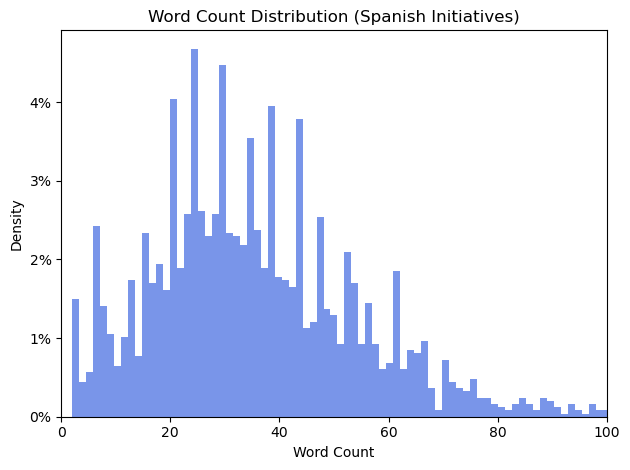

Min: 2
Max: 130
Mean: 35.983467741935485
Initiatives with < 3 words:
 ['Título I' 'Título II' 'Título III' 'Título V' 'Título VI' 'Título VII'
 'Título VIII' 'Anexos  null']


In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator, PercentFormatter

# Load your cleaned Spanish dataset
df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv")

# Compute word counts
df['word_count'] = df['initiative'].str.split().str.len()

# Drop NaNs if any
df = df[df['word_count'].notna()]
counts = df['word_count'].astype(int)

# Plot histogram
fig, ax = plt.subplots()

weights = np.ones_like(counts) / len(counts)

ax.hist(counts, bins=100, weights=weights, color="royalblue", alpha=0.7)

ax.set_xlabel("Word Count")
ax.set_ylabel("Density")
ax.set_title("Word Count Distribution (Spanish Initiatives)")

ax.yaxis.set_major_locator(MultipleLocator(0.01))
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
ax.set_xlim(0, 100)
plt.tight_layout()

# Save figure
plt.savefig("results_latex/word_counts_spanish.png")
plt.show()

# Print stats
print("Min:", counts.min())
print("Max:", counts.max())
print("Mean:", counts.mean())
print("Initiatives with < 3 words:\n", df[df['word_count'] < 3]['initiative'].unique())


✅ 1. Data Integrity & Filtering
The presence of ultra-short entries like 'Título I' indicates you may want to filter out structural fragments that were incorrectly included. These are not legitimate legislative texts, and LLMs would likely abstain or hallucinate responses to them.

📌 You can safely filter:

python
Kopiëren
Bewerken
df = df[df['word_count'] >= 5]
...to exclude structural artifacts and non-substantive motions.

✅ 2. Justification of Preprocessing
In your methodology section, you can now clearly state:

"We observed that a small subset of initiatives consisted of extremely short entries (e.g., 'Título II'), likely representing document section headers rather than substantive proposals. These were excluded from further analysis using a length threshold of 5 words, improving the semantic relevance of model inputs."

This demonstrates rigor in cleaning, and shows your dataset is truly composed of real legislative text.

✅ 3. Consistency Across Initiatives
The histogram also shows a healthy, relatively compact range of word lengths, which is good. If the distribution were extremely wide (e.g., 10 to 1,000+ words), you'd need to consider normalizing inputs, truncating, or splitting texts.

Since your max is 130, you're likely within safe bounds for all LLMs, even without truncation.

Functions

def heat_plot

In [117]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
import plotly.subplots as sp

def heat_plot(df, title, x, y, file_name, zmin=15, zmax=85, zmid=None, colorscale='blues'):
    df_array = np.array(df)

    # Create subplots
    fig = sp.make_subplots(
        rows=1, cols=1, 
        subplot_titles=(title,),
        vertical_spacing=0.15
    )
    fig.update_yaxes(autorange='reversed')

    # Heatmap trace
    positive_heatmap = go.Heatmap(
        z=df_array,
        x=x,
        y=y,
        colorscale=colorscale,
        zmin=zmin,
        zmax=zmax,
        zmid=zmid,
        colorbar=dict(title='(%)', x=1.02, y=0.5, len=0.9),
        text=df_array,
        texttemplate="%{text}",
        textfont={"size": 12},
    )
    fig.add_trace(positive_heatmap, row=1, col=1)

    # Dynamic margin adjustment
    max_y_label_length = max(len(str(label)) for label in y)+3
    max_x_label_length = max(len(str(label)) for label in x)+3

    margin_left = 80 + max_y_label_length * 7
    margin_bottom = 60 + max_x_label_length * 5

    fig.update_layout(
        height=110 + len(y) * 50 + max_x_label_length * 5,
        width=130 + len(x) * 80 + max_y_label_length * 7,
        showlegend=False,
        xaxis=dict(tickangle=0),
        yaxis=dict(tickmode='array', tickvals=np.arange(len(y)), ticktext=y),
        plot_bgcolor='white',
        paper_bgcolor='white',
        margin=dict(l=margin_left, b=margin_bottom)
    )

    fig.show()
    pio.write_image(fig, f"{results_latex_folder}/{file_name}.png", format='png')


Results Party Motions and Votes

Function - Motions

In [121]:
import pandas as pd

def create_motion_proposal_summary2(df_ideology, party_codes):
    
    return pd.DataFrame(motions_summary_data).set_index("Party")

Function - Votes

In [124]:
def create_vote_summary_df(df_ideology, party_cols, header="Party"):
    summary_data = []
    print("Total motions analyzed:", len(df_ideology))

    for col in party_cols:
        counts = df_ideology[col].value_counts().reindex([1.0, -1.0, 0.0], fill_value=0)
        proportions = df_ideology[col].value_counts(normalize=True).reindex([1.0, -1.0, 0.0], fill_value=0)

        summary_data.append({
            header: col,
            "Count of For": int(counts[1.0]),
            "Count of Against": int(counts[-1.0]),
            "Count of Other": int(counts[0.0]),
            "For (%)": f"{proportions[1.0]*100:.1f}",
            "Against (%)": f"{proportions[-1.0]*100:.1f}",
            "Other (%)": f"{proportions[0.0]*100:.1f}"
        })

    summary_df = pd.DataFrame(summary_data)
    return summary_df.set_index(header)

Initiatives

In [136]:
def get_df_initiative_summary_all(df_initiatives, party_codes):
    # -------------------------------------------
    # STEP 1: Extract year from date column
    # -------------------------------------------
    df_initiatives = df_initiatives.copy()
    df_initiatives["year"] = pd.to_datetime(df_initiatives["date"], dayfirst=True).dt.year

    # -------------------------------------------
    # STEP 2: Full-period summary
    # -------------------------------------------
    df_summary_all = create_motion_proposal_summary2(df_initiatives, party_codes)

    # -------------------------------------------
    # STEP 3: Define custom periods
    # -------------------------------------------
    periods = {
        "2016–2019": list(range(2016, 2020)),
        "2019–2023": list(range(2019, 2024)),
        "2023–2025": list(range(2023, 2026)),
    }

    # -------------------------------------------
    # STEP 4: Filter and compute summaries per period
    # -------------------------------------------
    summaries = {}
    for label, years in periods.items():
        mask = df_initiatives["year"].isin(years)
        summaries[label] = create_motion_proposal_summary2(df_initiatives[mask].copy(), party_codes)

    # -------------------------------------------
    # STEP 5: Rename columns
    # -------------------------------------------
    df_summary_all.rename(columns={"Motions (%)": "All"}, inplace=True)
    for label, df in summaries.items():
        df.rename(columns={"Motions (%)": label}, inplace=True)

    # -------------------------------------------
    # STEP 6: Merge all into one DataFrame
    # -------------------------------------------
    df_combined = pd.concat(
        [df_summary_all] + [summaries[label][label] for label in periods],
        axis=1,
        join="inner"
    )

    return df_combined


Initiative Stats

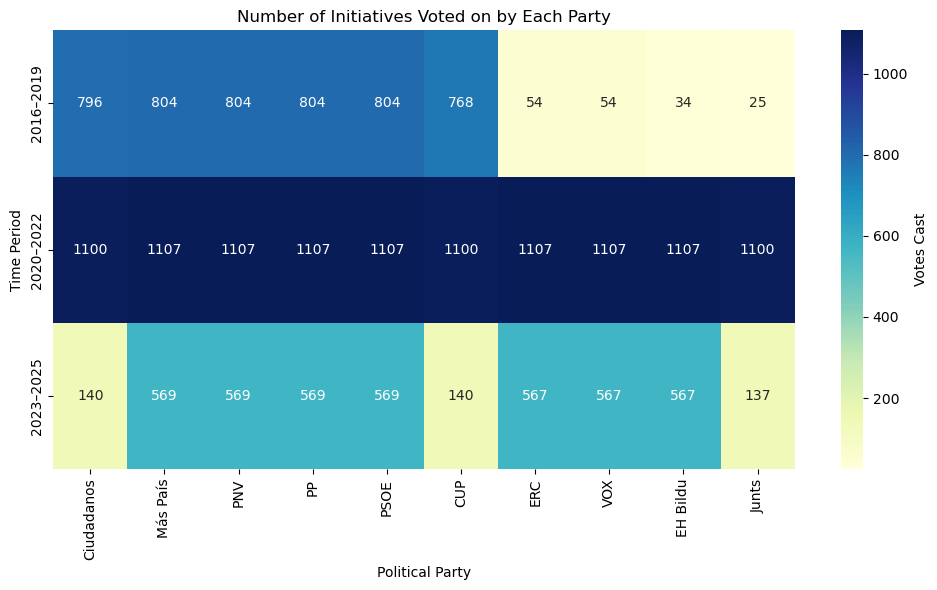

In [146]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------------------------------
# STEP 1: Load your dataset
# --------------------------------------------------
df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv")

# --------------------------------------------------
# STEP 2: Convert date to datetime and extract year
# --------------------------------------------------
df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True)
df["year"] = df["date"].dt.year

# --------------------------------------------------
# STEP 3: Define party columns and time periods
# --------------------------------------------------
party_cols = ['Ciudadanos', 'Más País', 'PNV', 'PP', 'PSOE', 'CUP',
              'ERC', 'VOX', 'EH Bildu', 'Junts']

# Define custom periods
periods = {
    "2016–2019": list(range(2016, 2020)),
    "2020–2022": list(range(2020, 2023)),
    "2023–2025": list(range(2023, 2026))
}

# --------------------------------------------------
# STEP 4: Count votes (i.e. non-null values) per party in each period
# --------------------------------------------------
summary = pd.DataFrame(index=party_cols)

for label, years in periods.items():
    mask = df["year"].isin(years)
    df_period = df.loc[mask, party_cols]
    
    # Count how many votes (non-null values) each party cast in this period
    counts = df_period.notna().sum()
    summary[label] = counts

# --------------------------------------------------
# STEP 5: Plot the heatmap
# --------------------------------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(summary.T, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={"label": "Votes Cast"})
plt.title("Number of Initiatives Voted on by Each Party")
plt.xlabel("Political Party")
plt.ylabel("Time Period")
plt.tight_layout()
plt.show()


Parties votes

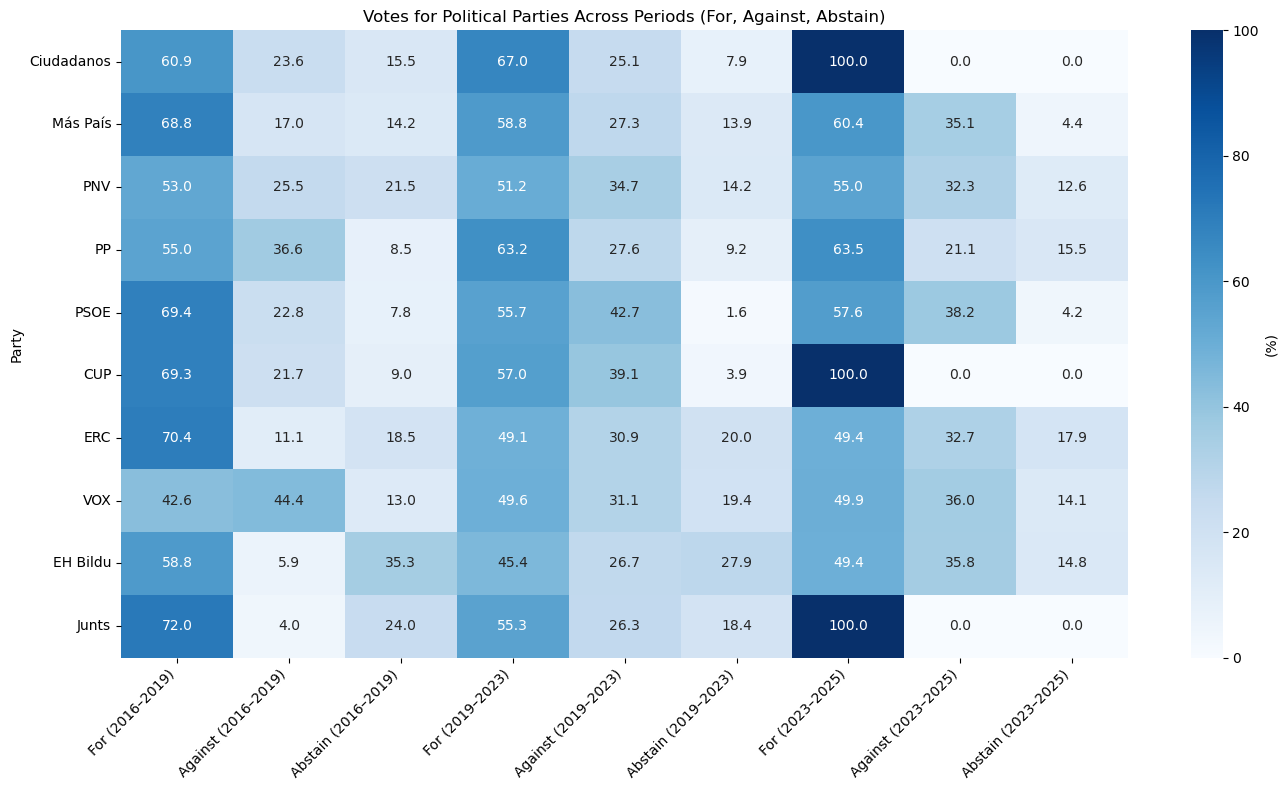

In [68]:
# -----------------------------------------------
# 1. Import libraries
# -----------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------------
# 2. Load your initiative vote data
# -----------------------------------------------
df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv")

# -----------------------------------------------
# 3. Convert date and assign period
# -----------------------------------------------
df["date"] = pd.to_datetime(df["date"], dayfirst=True)

# Define your parliamentary periods
periods = {
    "2016–2019": (pd.Timestamp("2016-01-01"), pd.Timestamp("2019-12-31")),
    "2019–2023": (pd.Timestamp("2020-01-01"), pd.Timestamp("2023-06-30")),
    "2023–2025": (pd.Timestamp("2023-07-01"), pd.Timestamp("2025-12-31")),
}

# Assign a period to each row
def assign_period(date):
    for label, (start, end) in periods.items():
        if start <= date <= end:
            return label
    return None

df["period"] = df["date"].apply(assign_period)

# -----------------------------------------------
# 4. Prepare vote summary function (with Abstain)
# -----------------------------------------------
party_columns = ['Ciudadanos', 'Más País', 'PNV', 'PP', 'PSOE', 'CUP', 'ERC', 'VOX', 'EH Bildu', 'Junts']

def create_vote_summary(df_slice):
    summary = {}
    for party in party_columns:
        total = df_slice[party].notna().sum()
        if total == 0:
            summary[party] = {"For": 0, "Against": 0, "Abstain": 0}
            continue
        votes_for = (df_slice[party] == 1).sum() / total * 100
        votes_against = (df_slice[party] == -1).sum() / total * 100
        votes_abstain = (df_slice[party] == 0).sum() / total * 100
        summary[party] = {
            "For": votes_for,
            "Against": votes_against,
            "Abstain": votes_abstain
        }
    return pd.DataFrame(summary).T

# -----------------------------------------------
# 5. Calculate summaries for each period
# -----------------------------------------------
df_vote_summary_all = pd.DataFrame()

for label in periods:
    summary = create_vote_summary(df[df["period"] == label])
    summary.columns = [f"{col} ({label})" for col in summary.columns]
    df_vote_summary_all = pd.concat([df_vote_summary_all, summary], axis=1)

# -----------------------------------------------
# 6. Plot heatmap
# -----------------------------------------------
plt.figure(figsize=(14, 8))
sns.heatmap(df_vote_summary_all, annot=True, fmt=".1f", cmap="Blues", cbar_kws={"label": "(%)"})
plt.title("Votes for Political Parties Across Periods (For, Against, Abstain)")
plt.ylabel("Party")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Agreement amongst parties

Mean off-diagonal similarity: 53.5%


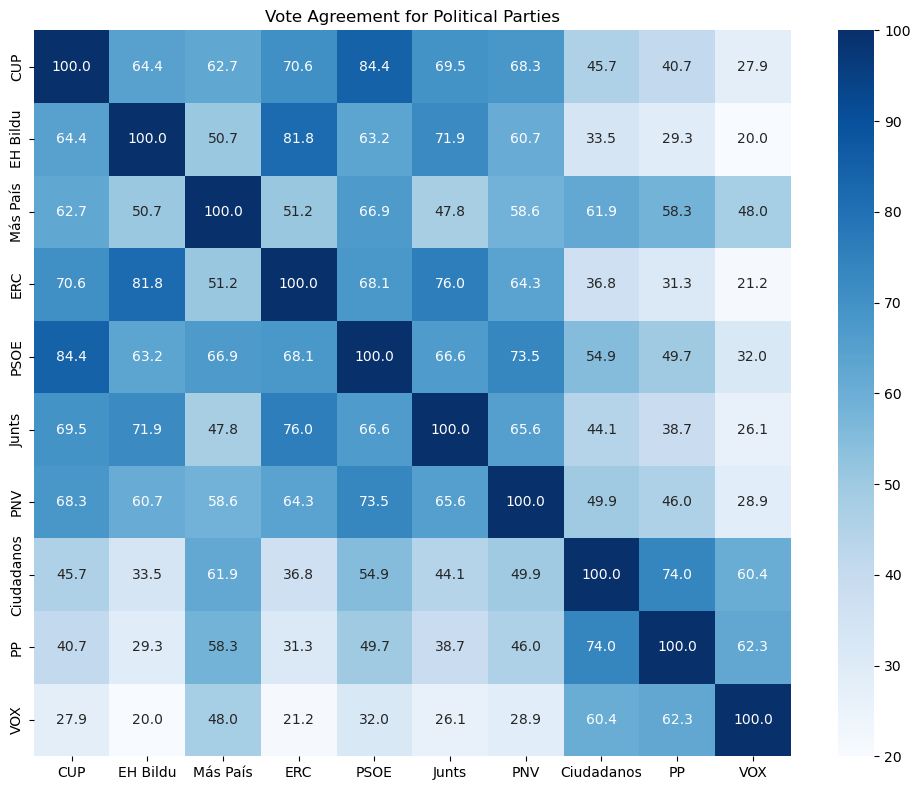

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------------------------
# 1. Load your data
# -----------------------------------------------
df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv")
df["date"] = pd.to_datetime(df["date"], dayfirst=True)

# -----------------------------------------------
# 2. Define the party codes (your 10 parties)
# -----------------------------------------------
party_codes = ['CUP', 'EH Bildu', 'Más País', 'ERC', 'PSOE',
                   'Junts', 'PNV', 'Ciudadanos', 'PP', 'VOX']

party_codes_left_right = [  # sorted roughly by CHES left-right
    'CUP', 'EH Bildu', 'Más País', 'ERC', 'PSOE',
    'Junts', 'PNV', 'Ciudadanos', 'PP', 'VOX'
]

# -----------------------------------------------
# 3. Create Agreement Matrix
# -----------------------------------------------
df_agreement_parties = pd.DataFrame(index=party_codes, columns=party_codes, dtype=float)

for p1 in party_codes:
    for p2 in party_codes:
        mask = df[p1].notna() & df[p2].notna()
        total_shared = mask.sum()
        
        if total_shared == 0:
            df_agreement_parties.loc[p1, p2] = np.nan
            continue

        if p1 == p2:
            df_agreement_parties.loc[p1, p2] = 100.0
        else:
            same_votes = (df.loc[mask, p1] == df.loc[mask, p2]).sum()
            df_agreement_parties.loc[p1, p2] = round(100 * same_votes / total_shared, 1)
# -----------------------------------------------
# 4. Compute Mean Off-Diagonal Similarity
# -----------------------------------------------
mask = ~np.eye(len(party_codes), dtype=bool)

mean_similarity = (
    df_agreement_parties
    .where(mask)
    .stack()
    .mean()
)

print(f"Mean off-diagonal similarity: {mean_similarity:.1f}%")

# If using LaTeX output helper, otherwise skip this line
# write_latex_variable("partyvoteagreement", f"{mean_similarity:.1f}%")

# -----------------------------------------------
# 5. Heatmap of Agreement
# -----------------------------------------------
def heat_plot(df, title, xlabels, ylabels, filename):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, fmt=".1f", cmap="Blues", xticklabels=xlabels, yticklabels=ylabels)
    plt.title(title)
    plt.tight_layout()
    plt.show()

heat_plot(
    df_agreement_parties[party_codes_left_right].T,
    "Vote Agreement for Political Parties",
    party_codes_left_right,
    party_codes_left_right,
    "vote_agreement_parties"
)


LLM Votes

In [104]:
import pandas as pd

# -----------------------------------------------
# 1. Input files and expected columns
# -----------------------------------------------
files = [
    "Second_Experiments_Results/deepseek_7b_results_ideology_ES_prompt=1.csv",
    "Second_Experiments_Results/falcon3_7b_results_ideology_ES_prompt=1.csv",
    "Second_Experiments_Results/gemma2_9b_results_ideology_ES_prompt=1.csv",
    "Second_Experiments_Results/llama3_8b_results_ideology_ES_prompt=1.csv",
    "Second_Experiments_Results/mistral_7b_results_ideology_ES_prompt=1.csv"
]

cols = [
    'deepseek_7b_vote',
    'falcon3_7b_vote',
    'gemma2_9b_vote',
    'llama3_8b_vote',
    'mistral_7b_vote'
]

# -----------------------------------------------
# 2. Count vote % for each model
# -----------------------------------------------
pct_dict = {}

for path, col in zip(files, cols):
    df = pd.read_csv(path)

    # Ensure votes are numeric (e.g. 1, 0, -1)
    df[col] = pd.to_numeric(df[col], errors='coerce')

    # Count % of each vote type
    pct = (
        df[col]
        .value_counts(normalize=True)
        .mul(100)
        .round(1)
    )

    model = col.replace('_vote', '')
    pct_dict[model] = pct

# -----------------------------------------------
# 3. Create summary table
# -----------------------------------------------
pct_df = pd.DataFrame(pct_dict).fillna(0).sort_index()

print(pct_df)

    deepseek_7b  falcon3_7b  gemma2_9b  llama3_8b  mistral_7b
-1         16.2        25.7        0.0        0.1         0.0
 0         13.8        63.1       97.7        6.4         0.6
 1         70.0        11.2        2.3       93.5        99.4


Stylized Facts

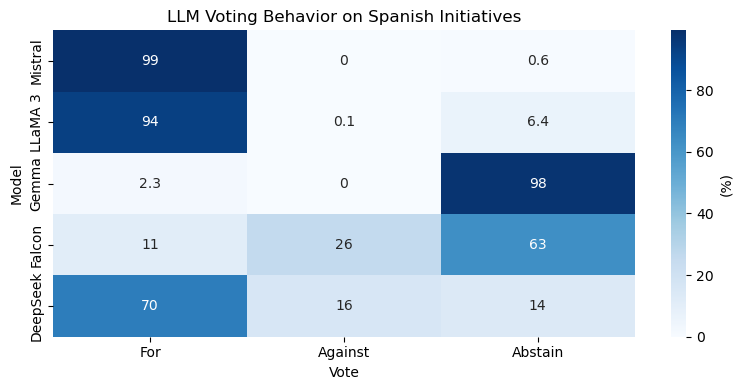

In [174]:
import pandas as pd

# ---------------------------------------------
# 1. Load Your Spanish LLM Vote Data
# ---------------------------------------------
df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/all_initiatives_full_with_llm_votes.csv")

model_names = ['mistral_7b', 'llama3_8b', 'gemma2_9b', 'falcon3_7b', 'deepseek_7b']
model_names_short = ['Mistral', 'LLaMA 3', 'Gemma', 'Falcon', 'DeepSeek']
model_rename_dict = dict(zip(model_names, model_names_short))

# ---------------------------------------------
# 2. Create Vote Summary (% For / Against / Abstain)
# ---------------------------------------------
def create_vote_summary_df(df, vote_cols, label):
    summary = []
    for col in vote_cols:
        counts = df[col].value_counts(normalize=True).round(3) * 100
        for_ = counts.get(1, 0)
        against = counts.get(-1, 0)
        abstain = counts.get(0, 0)
        summary.append([col, for_, against, abstain])
    summary_df = pd.DataFrame(summary, columns=[label, "For", "Against", "Abstain"])
    return summary_df

summary_df_models = create_vote_summary_df(df, model_names, "LLMs")

# Rename to short names
summary_df_models["LLMs"] = summary_df_models["LLMs"].map(model_rename_dict)

# Set LLMs as index
summary_df_models.set_index("LLMs", inplace=True)

# ---------------------------------------------
# 3. Plot the Heatmap of Vote Tendencies
# ---------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.heatmap(summary_df_models[["For", "Against", "Abstain"]],
            annot=True, cmap="Blues", cbar_kws={"label": "(%)"})
plt.title("LLM Voting Behavior on Spanish Initiatives")
plt.xlabel("Vote")
plt.ylabel("Model")
plt.tight_layout()
plt.show()


Ideology

PCA POLITICAL LANDSCAPE

Fit on parties, transform on models¶

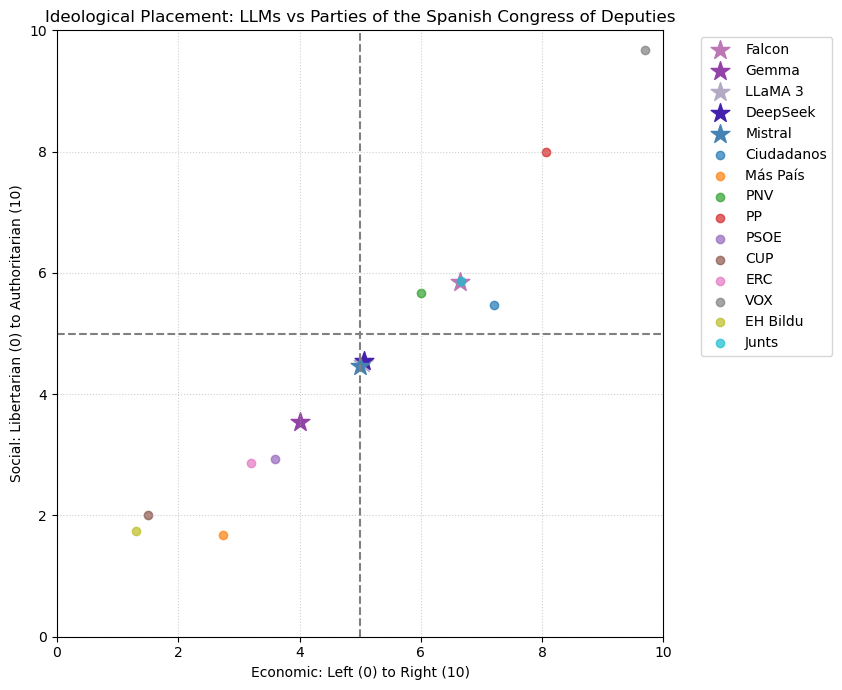

In [118]:
# -----------------------------------------------
# STEP 1: Import Libraries
# -----------------------------------------------
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# -----------------------------------------------
# STEP 2: Load the Wide-Format Vote Dataset
# -----------------------------------------------
# This version already has each model as a separate column

full_df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/all_initiatives_full_with_llm_votes.csv")

# -----------------------------------------------
# STEP 3: Define Party and LLM Columns
# -----------------------------------------------
party_cols = ['Ciudadanos', 'Más País', 'PNV', 'PP', 'PSOE', 'CUP', 'ERC', 'VOX', 'EH Bildu', 'Junts']
llm_cols = ['falcon3_7b', 'gemma2_9b', 'llama3_8b', 'deepseek_7b', 'mistral_7b']


# -----------------------------------------------
# STEP 4: Extract the Vote Matrix and Clean It
# -----------------------------------------------
# Replace missing votes with 0 (abstain/neutral)
vote_matrix = full_df[party_cols + llm_cols].fillna(0)

# -----------------------------------------------
# STEP 5: Transpose for Vector Comparison
# -----------------------------------------------
# Rows = entities, Columns = initiatives
party_vectors = vote_matrix[party_cols].T
llm_vectors = vote_matrix[llm_cols].T

# -----------------------------------------------
# STEP 6: Define CHES Coordinates for Parties
# -----------------------------------------------
lrgen_dict = {'Ciudadanos': 7.2, 'Más País': 2.73, 'PNV': 6.0, 'PP': 8.07, 'PSOE': 3.6,
              'CUP': 1.5, 'ERC': 3.2, 'VOX': 9.7, 'EH Bildu': 1.3, 'Junts': 6.67}

galtan_dict = {'Ciudadanos': 5.47, 'Más País': 1.67, 'PNV': 5.67, 'PP': 8.0, 'PSOE': 2.93,
               'CUP': 2.0, 'ERC': 2.87, 'VOX': 9.67, 'EH Bildu': 1.75, 'Junts': 5.87}

lrgen_array = np.array([lrgen_dict[p] for p in party_cols])
galtan_array = np.array([galtan_dict[p] for p in party_cols])

# -----------------------------------------------
# STEP 7: Compute Cosine Similarity (LLMs vs Parties)
# -----------------------------------------------
similarities = cosine_similarity(llm_vectors, party_vectors)

# -----------------------------------------------
# STEP 8: Compute Weighted CHES Coordinates for Each LLM
# -----------------------------------------------
llm_lrgen = similarities @ lrgen_array / similarities.sum(axis=1)
llm_galtan = similarities @ galtan_array / similarities.sum(axis=1)

llm_positions = pd.DataFrame({
    "lrgen": llm_lrgen,
    "galtan": llm_galtan
}, index=llm_cols)

# -----------------------------------------------
# STEP 9: Plot LLMs and Parties on the CHES Grid
# -----------------------------------------------
plt.figure(figsize=(8, 7))

# Use the actual index values from the DataFrame
model_names = llm_positions.index.tolist()

# Make sure you have the same number of colors
colors_models = ['#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#4682B4']

# Define friendly display names (same order as colors)
label_map = {
    'mistral_7b': 'Mistral',
    'falcon3_7b': 'Falcon',
    'gemma2_9b': 'Gemma',
    'deepseek_7b': 'DeepSeek',
    'llama3_8b': 'LLaMA 3'
} 

# Plot LLMs (as stars with custom colors)
for llm, color in zip(model_names, colors_models):
    plt.scatter(llm_positions.loc[llm, 'lrgen'], llm_positions.loc[llm, 'galtan'],
                color=color, marker='*', s=200, label=label_map.get(llm, llm))

# Plot parties (default matplotlib colors)
for party in party_cols:
    plt.scatter(lrgen_dict[party], galtan_dict[party], label=party, alpha=0.7)

# Format the plot
plt.axhline(y=5, color='gray', linestyle='--')
plt.axvline(x=5, color='gray', linestyle='--')
plt.xlabel("Economic: Left (0) to Right (10)")
plt.ylabel("Social: Libertarian (0) to Authoritarian (10)")
plt.title("Ideological Placement: LLMs vs Parties of the Spanish Congress of Deputies")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Explained variance ratio: [0.28420327 0.18582649]


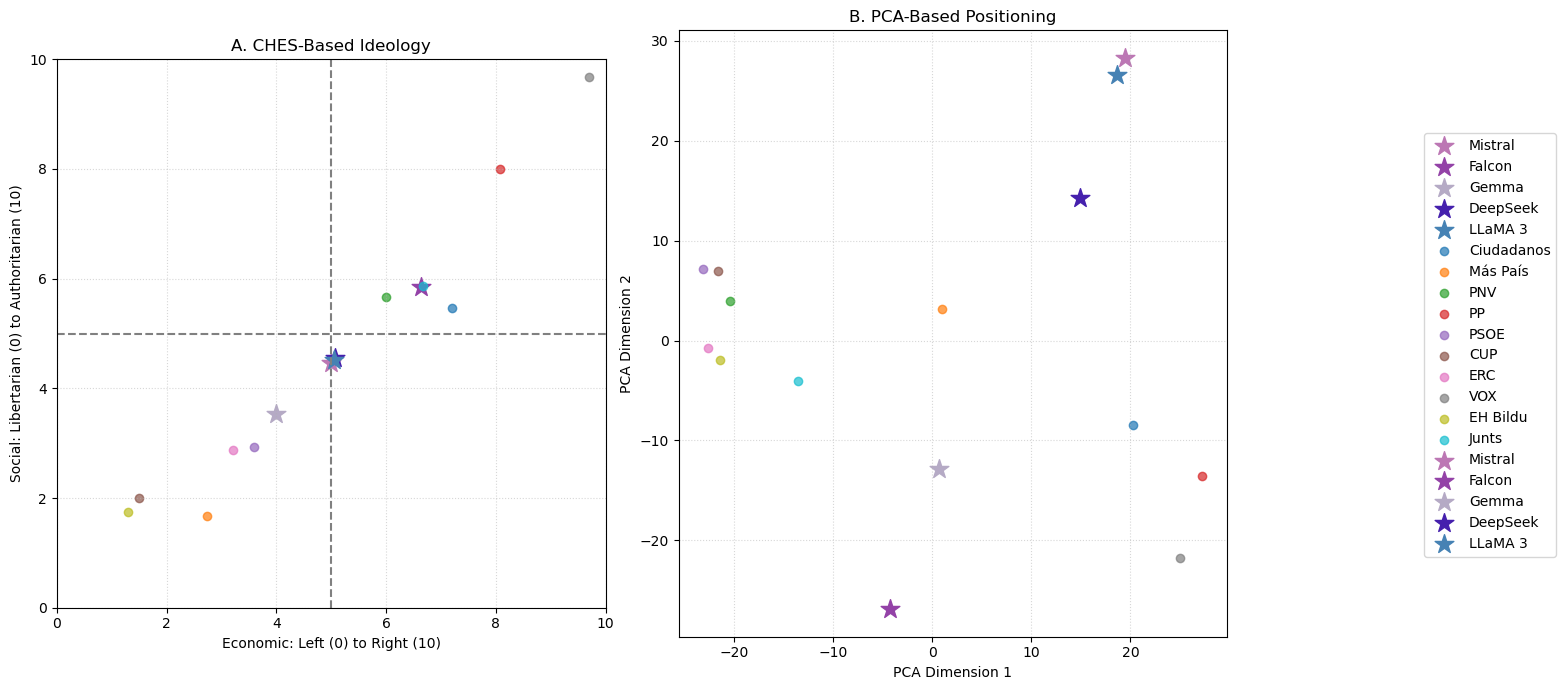

In [126]:
# -----------------------------------------------
# STEP 1: Import Libraries
# -----------------------------------------------
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# -----------------------------------------------
# STEP 2: Load the Wide-Format Vote Dataset
# -----------------------------------------------
# This version already has each model as a separate column

full_df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/all_initiatives_full_with_llm_votes.csv")

# -----------------------------------------------
# STEP 3: Define Entities
# -----------------------------------------------
party_cols = ['Ciudadanos', 'Más País', 'PNV', 'PP', 'PSOE', 'CUP', 'ERC', 'VOX', 'EH Bildu', 'Junts']
model_names = ['mistral_7b', 'falcon3_7b', 'gemma2_9b', 'deepseek_7b', 'llama3_8b']
colors_models = ['#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#4682B4']

# Optional cleaner names for legend
label_map = {
    'mistral_7b': 'Mistral',
    'falcon3_7b': 'Falcon',
    'gemma2_9b': 'Gemma',
    'deepseek_7b': 'DeepSeek',
    'llama3_8b': 'LLaMA 3'
}

# -----------------------------------------------
# STEP 4: Prepare Voting Matrix
# -----------------------------------------------
vote_matrix = full_df[party_cols + model_names].fillna(0)
party_vectors = vote_matrix[party_cols].T
llm_vectors = vote_matrix[model_names].T

# -----------------------------------------------
# STEP 5: CHES Coordinates and Cosine Similarity
# -----------------------------------------------
lrgen_dict = {'Ciudadanos': 7.2, 'Más País': 2.73, 'PNV': 6.0, 'PP': 8.07, 'PSOE': 3.6,
              'CUP': 1.5, 'ERC': 3.2, 'VOX': 9.7, 'EH Bildu': 1.3, 'Junts': 6.67}
galtan_dict = {'Ciudadanos': 5.47, 'Más País': 1.67, 'PNV': 5.67, 'PP': 8.0, 'PSOE': 2.93,
               'CUP': 2.0, 'ERC': 2.87, 'VOX': 9.67, 'EH Bildu': 1.75, 'Junts': 5.87}

lrgen_array = np.array([lrgen_dict[p] for p in party_cols])
galtan_array = np.array([galtan_dict[p] for p in party_cols])

similarities = cosine_similarity(llm_vectors, party_vectors)
llm_lrgen = similarities @ lrgen_array / similarities.sum(axis=1)
llm_galtan = similarities @ galtan_array / similarities.sum(axis=1)

llm_ches_df = pd.DataFrame({
    'lrgen': llm_lrgen,
    'galtan': llm_galtan
}, index=model_names)

# -----------------------------------------------
# STEP 6: PCA-Based Projection
# -----------------------------------------------
pca = PCA(n_components=2)
entity_matrix = vote_matrix[party_cols + model_names].T
pca_coords = pca.fit_transform(entity_matrix)
pca_df = pd.DataFrame(pca_coords, columns=["PC1", "PC2"], index=party_cols + model_names)

# -----------------------------------------------
# STEP 7: Plot Both Ideological Landscapes
# -----------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# ---- CHES Grid ----
ax = axes[0]
for model, color in zip(model_names, colors_models):
    ax.scatter(llm_ches_df.loc[model, 'lrgen'], llm_ches_df.loc[model, 'galtan'],
               color=color, marker='*', s=200, label=label_map.get(model, model))
for party in party_cols:
    ax.scatter(lrgen_dict[party], galtan_dict[party], label=party, alpha=0.7)
ax.axhline(5, color='gray', linestyle='--')
ax.axvline(5, color='gray', linestyle='--')
ax.set_title("A. CHES-Based Ideology")
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_xlabel("Economic: Left (0) to Right (10)")
ax.set_ylabel("Social: Libertarian (0) to Authoritarian (10)")
ax.set_aspect('equal')
ax.grid(True, linestyle=':', alpha=0.5)

# ---- PCA Projection ----
ax = axes[1]
for model, color in zip(model_names, colors_models):
    ax.scatter(pca_df.loc[model, 'PC1'], pca_df.loc[model, 'PC2'],
               color=color, marker='*', s=200, label=label_map.get(model, model))
for party in party_cols:
    ax.scatter(pca_df.loc[party, 'PC1'], pca_df.loc[party, 'PC2'], alpha=0.7)
ax.set_title("B. PCA-Based Positioning")
ax.set_xlabel("PCA Dimension 1")
ax.set_ylabel("PCA Dimension 2")
ax.grid(True, linestyle=':', alpha=0.5)

print("Explained variance ratio:", pca.explained_variance_ratio_)


# ---- Shared Legend ----
fig.legend(loc='center right', bbox_to_anchor=(1.12, 0.5))
plt.tight_layout()
plt.subplots_adjust(right=0.88)
plt.show()

Summary:
Left panel = CHES-weighted positioning (ideologically meaningful)
Right panel = PCA projection (data-driven clustering)